In [ ]:
# Esta celda:
# - Lee el dataset de features finales
# - Selecciona las columnas numéricas relevantes

import numpy as np
import pandas as pd
import logging

# Leer datos
data_full = pd.read_csv(
    r"C:\dev\EyF_churn_2025-02\data\processed\competencia_02_features_new.csv"
)

PERIOD_COL = "foto_mes"

# Columnas que no quiero considerar como features numéricas
cols_excluir = [
    PERIOD_COL,
    "numero_de_cliente",
    "clase_ternaria",
    "clase_binaria",
]

numeric_cols = [
    c for c in data_full.select_dtypes(include=["number"]).columns
    if c not in cols_excluir
]

# 1.-Drift mediante Population Stability Index

In [ ]:
# - Define un conjunto de meses de entrenamiento como baseline
# - Calcula el PSI (Population Stability Index) por variable y mes
# - Resume por mes y marca qué meses tienen drift fuerte

# Configuración básica de logging (solo hace falta definirla una vez en el notebook)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S",
)
logger = logging.getLogger("drift_check")

# Meses disponibles y meses que uso como baseline de entrenamiento (ajustar si hace falta)
all_months = sorted(data_full[PERIOD_COL].unique())
train_months = all_months[-19:]   # últimos 19 meses como baseline de entrenamiento
baseline = data_full[data_full[PERIOD_COL].isin(train_months)]

def psi(expected, actual, buckets=10, eps=1e-8):
    """
    Calcula PSI entre la distribución baseline (expected)
    y el mes que quiero comparar (actual).
    """
    expected = np.asarray(expected)
    actual = np.asarray(actual)

    # Filtrar NaN
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]
    if len(expected) == 0 or len(actual) == 0:
        return np.nan

    # Cortes por cuantiles de la distribución baseline
    qs = np.linspace(0, 1, buckets + 1)
    cuts = np.unique(np.quantile(expected, qs))
    if len(cuts) < 2:
        return 0.0

    e_hist, _ = np.histogram(expected, bins=cuts)
    a_hist, _ = np.histogram(actual, bins=cuts)

    e_perc = e_hist / e_hist.sum()
    a_perc = a_hist / a_hist.sum()

    e_perc = np.clip(e_perc, eps, 1)
    a_perc = np.clip(a_perc, eps, 1)

    return np.sum((e_perc - a_perc) * np.log(e_perc / a_perc))


logger.info("Iniciando cálculo de drift por mes")
logger.info("Total de meses detectados: %d", len(all_months))
logger.info("Meses baseline (train_months): %s", train_months)

drift_rows = []
for idx, m in enumerate(all_months, start=1):
    df_m = data_full[data_full[PERIOD_COL] == m]
    if df_m.empty:
        logger.warning("Mes %s sin registros, se omite", m)
        continue

    logger.info(
        "Procesando mes %s (%d/%d) - n_registros=%d",
        m, idx, len(all_months), len(df_m)
    )

    vals = {}
    for col in numeric_cols:
        vals[col] = psi(baseline[col].values, df_m[col].values, buckets=10)

    s = pd.Series(vals)

    avg_psi = s.mean(skipna=True)
    max_psi = s.max(skipna=True)
    n_gt_02 = (s > 0.2).sum()
    n_gt_03 = (s > 0.3).sum()

    logger.info(
        "Mes %s -> avg_psi=%.4f, max_psi=%.4f, n_cols_psi>0.2=%d, n_cols_psi>0.3=%d",
        m, avg_psi, max_psi, n_gt_02, n_gt_03
    )

    drift_rows.append(
        {
            PERIOD_COL: m,
            "avg_psi": avg_psi,
            "max_psi": max_psi,
            "n_cols_psi_gt_0_2": n_gt_02,
            "n_cols_psi_gt_0_3": n_gt_03,
        }
    )

drift_summary = pd.DataFrame(drift_rows).sort_values(PERIOD_COL)
drift_summary["drift_flag"] = (
    (drift_summary["avg_psi"] > 0.2)
    | (drift_summary["n_cols_psi_gt_0_3"] > len(numeric_cols) * 0.2)
)

months_with_drift = drift_summary.loc[drift_summary["drift_flag"], PERIOD_COL].tolist()

logger.info("Cálculo de drift finalizado")
logger.info("Meses marcados con drift: %s", months_with_drift)

drift_summary, months_with_drift



C:\Users\josep\AppData\Local\Temp\ipykernel_11184\1439304394.py:35: RuntimeWarning: invalid value encountered in divide
  a_perc = a_hist / a_hist.sum()


(    foto_mes   avg_psi    max_psi  n_cols_psi_gt_0_2  n_cols_psi_gt_0_3  \
 0     201901  1.015161  16.877525                 44                 36   
 1     201902  0.603186  16.877525                 49                 41   
 2     201903  0.506102  16.877525                 47                 37   
 3     201904  0.586479  16.877525                 46                 33   
 4     201905  0.932350  17.495263                 42                 32   
 5     201906  0.333672  16.877525                 31                 22   
 6     201907  0.304006  16.877525                 30                 21   
 7     201908  0.291876  15.259524                 28                 18   
 8     201909  0.276185  15.251070                 23                 17   
 9     201910  0.767159  17.495263                 28                 21   
 10    201911  0.261359  15.200297                 16                 11   
 11    201912  0.252968  15.181884                 14                 11   
 12    20200

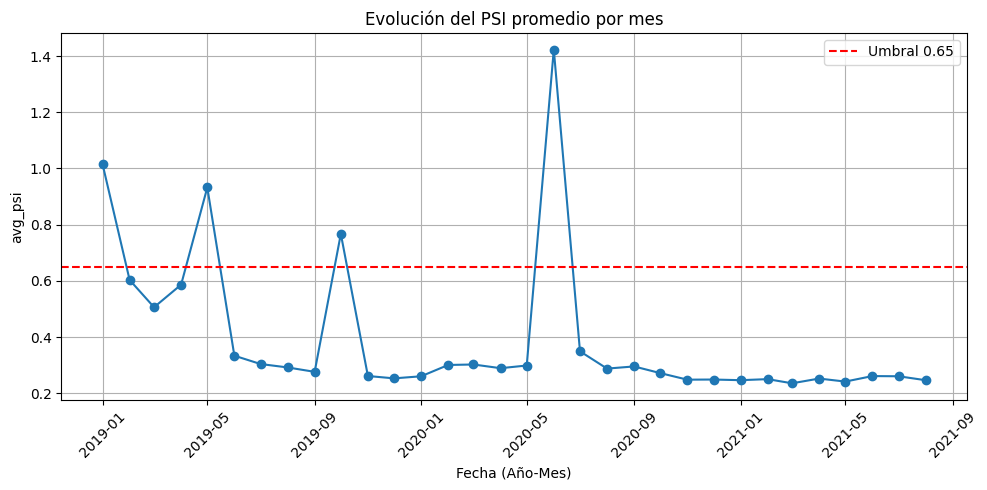

In [8]:
# Esta celda grafica la evolución del PSI promedio por mes (avg_psi)
# con el eje de tiempo formateado como Año-Mes (YYYY-MM).

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df_drift_plot = drift_summary.copy()
df_drift_plot["fecha"] = pd.to_datetime(df_drift_plot[PERIOD_COL].astype(str), format="%Y%m")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_drift_plot["fecha"], df_drift_plot["avg_psi"], marker="o")
ax.axhline(0.65, linestyle="--", color="red", label="Umbral 0.65")

ax.set_title("Evolución del PSI promedio por mes")
ax.set_xlabel("Fecha (Año-Mes)")
ax.set_ylabel("avg_psi")

# Formato del eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2.-Outliers

In [10]:
# Esta celda:
# - Calcula el rango intercuartílico (IQR) global por variable numérica
# - Define outliers fuertes como valores fuera de [Q1 - 3*IQR, Q3 + 3*IQR]
# - Para cada mes, mide la proporción de outliers por variable
# - Resume por mes y marca meses con tasas altas de outliers
# - Combina meses con drift y con outliers para obtener una lista de meses a descartar

import logging

logger = logging.getLogger("outlier_check")

logger.info("Iniciando cálculo de outliers por mes")
logger.info("Total de meses detectados: %d", len(all_months))

# IQR global por variable
q1 = data_full[numeric_cols].quantile(0.25)
q3 = data_full[numeric_cols].quantile(0.75)
iqr = q3 - q1

lower = q1 - 3 * iqr
upper = q3 + 3 * iqr

logger.info("IQR global calculado para %d columnas numéricas", len(numeric_cols))

out_rows = []
for idx, m in enumerate(all_months, start=1):
    df_m = data_full[data_full[PERIOD_COL] == m]
    if df_m.empty:
        logger.warning("Mes %s sin registros, se omite", m)
        continue

    logger.info(
        "Procesando mes %s (%d/%d) - n_registros=%d",
        m, idx, len(all_months), len(df_m)
    )

    rates = {}
    for col in numeric_cols:
        col_vals = df_m[col]
        if col_vals.isna().all():
            rates[col] = np.nan
            continue
        mask = (col_vals < lower[col]) | (col_vals > upper[col])
        rates[col] = mask.mean()

    s = pd.Series(rates)

    avg_out = s.mean(skipna=True)
    max_out = s.max(skipna=True)
    n_gt_5 = (s > 0.05).sum()
    n_gt_10 = (s > 0.10).sum()

    logger.info(
        "Mes %s -> avg_outlier_rate=%.4f, max_outlier_rate=%.4f, "
        "n_cols_out_rate>5%%=%d, n_cols_out_rate>10%%=%d",
        m, avg_out, max_out, n_gt_5, n_gt_10
    )

    out_rows.append(
        {
            PERIOD_COL: m,
            "avg_outlier_rate": avg_out,
            "max_outlier_rate": max_out,
            "n_cols_out_rate_gt_5pct": n_gt_5,
            "n_cols_out_rate_gt_10pct": n_gt_10,
        }
    )

outlier_summary = pd.DataFrame(out_rows).sort_values(PERIOD_COL)
outlier_summary["outlier_flag"] = (
    (outlier_summary["avg_outlier_rate"] > 0.05)
    | (outlier_summary["n_cols_out_rate_gt_10pct"] > len(numeric_cols) * 0.2)
)

months_with_outliers = outlier_summary.loc[
    outlier_summary["outlier_flag"], PERIOD_COL
].tolist()

# Meses candidatos a sacar del entrenamiento (por drift o por outliers)
months_to_drop = sorted(set(months_with_drift) | set(months_with_outliers))

logger.info("Cálculo de outliers finalizado")
logger.info("Meses con outliers fuertes: %s", months_with_outliers)
logger.info("Meses candidatos a eliminar (drift u outliers): %s", months_to_drop)

outlier_summary, months_with_outliers, months_to_drop

outlier_summary, months_with_outliers, months_to_drop


(    foto_mes  avg_outlier_rate  max_outlier_rate  n_cols_out_rate_gt_5pct  \
 0     201901          0.047613          0.823936                       61   
 1     201902          0.045371          0.446655                       67   
 2     201903          0.042609          0.327991                       63   
 3     201904          0.042250          0.301222                       60   
 4     201905          0.040805          0.300325                       56   
 5     201906          0.042039          0.288712                       60   
 6     201907          0.044898          0.301670                       63   
 7     201908          0.044427          0.311178                       58   
 8     201909          0.043964          0.311864                       60   
 9     201910          0.045000          0.330961                       60   
 10    201911          0.044050          0.303313                       60   
 11    201912          0.047071          0.316267               

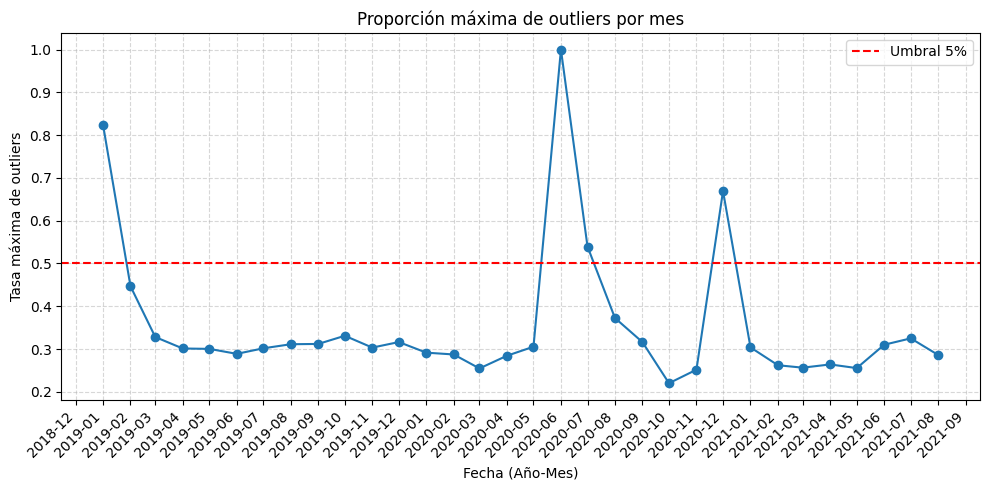

In [15]:
# Esta celda grafica la proporción máxima de outliers por mes
# usando un eje temporal con formato Año-Mes y ejes más legibles.

df_out_plot = outlier_summary.copy()
df_out_plot["fecha"] = pd.to_datetime(df_out_plot[PERIOD_COL].astype(str), format="%Y%m")
df_out_plot = df_out_plot.sort_values("fecha")

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df_out_plot["fecha"], df_out_plot["max_outlier_rate"], marker="o")

# Línea de referencia (ajusta el umbral si aplica)
ax.axhline(0.5, linestyle="--", color="red", label="Umbral 5%")

ax.set_title("Proporción máxima de outliers por mes")
ax.set_xlabel("Fecha (Año-Mes)")
ax.set_ylabel("Tasa máxima de outliers")

# Formato del eje X
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # cambia el intervalo si hay muchos meses

plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

